# Enrichment of regulons from Regulons_by_strain

In [68]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)
    
import warnings

import pandas as pd
from IPython.display import display
pd.set_option('max_colwidth', 70)
pd.set_option('display.max_rows', 500)
import string
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0})

from orangecontrib.bioinformatics.geneset.__init__ import list_all

import jupyter_functions as jf
reload(jf)
import jupyter_functions as jf
from functionsDENet import loadPickle, savePickle
import stages_DE.enrichment_library as enr
reload(enr)
import stages_DE.enrichment_library as enr

In [2]:
#Path for expression data (mergedGenes_RPKUM.tsv)
dataPath='/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
#Path for regulons
pathRegulons='/home/karin/Documents/timeTrajectories/data/regulons/by_strain/kN300_mean0std1_log/'

## Used gene sets
Use gene sets that do not have less than 5 or more than 500 genes. Use all ontologies.

In [16]:
# Get all gene sets
gene_sets=list(list_all(organism='44689'))
GENE_SETS_ONTOLOGY=enr.get_gene_sets(gene_set_names=gene_sets, go_slims=True,set_sizes=(5,500))

In [17]:
# Find out max/min gene set sizes and N sets
max_n=0
min_n=np.inf
for k,v in GENE_SETS_ONTOLOGY.items():
    for s in v:
        n=len(s.genes)
        if n<min_n:
            min_n=n
        if n>max_n:
            max_n=n
print('Min size',min_n,'Max size',max_n)  
print('N sets',{k:len(v) for k,v in GENE_SETS_ONTOLOGY.items()})

Min size 5 Max size 495
N sets {('GO', 'molecular_function'): 35, ('GO', 'biological_process'): 52, ('KEGG', 'Pathways'): 96, ('GO', 'cellular_component'): 24, ('Dictybase', 'Phenotypes'): 209, ('Custom', 'Baylor'): 15}


In [5]:
# For conversion of gene names to EID
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
all_gene_names= genes[(genes != 0).any(axis=1)].index
NAME_EID=enr.name_genes_entrez(gene_names=all_gene_names, key_entrez=False)
ALL_GENE_NAMES_EID=enr.convert_EID(genes=all_gene_names, name_EID=NAME_EID)

In [25]:
#OLD CODE!!!!!!!!!!!!!!!!!!!
def group_diff_enrichment(data:pd.DataFrame,group:str,padj:float=0.25,min_overlap:int=None,
                          use_annotated_genes:bool=False,enrichment_map=False):
    #Displays only gene sets that have overlap with query greater or equal to min_overlap 
    #For p value and padj calculation uses alll that have overlap >=1 } from gene_set_enrichment
    """
    :param use_annotated_genes: if True use for reference and query  only genes that have at 
    least one gene set annotation
    """
    selected=list(data[data['Cluster']==group].index)
    query_EID=enr.convert_EID(genes=selected, name_EID=NAME_EID)
    print('***  '+group+' selected:',len(selected),'with EID:',len(query_EID))
    
    reference_gene_eids=ALL_GENE_NAMES_EID.copy()
    query_eids=query_EID.copy()
    
    if use_annotated_genes:
        gene_sets_genes=set()
        for gene_set_name, gene_sets in GENE_SETS_ONTOLOGY.items():
            for gene_set in gene_sets:
                gene_sets_genes.update(gene_set.genes)
        reference_gene_eids=set(reference_gene_eids) & gene_sets_genes
        query_eids=set(query_eids) & gene_sets_genes
        print('Ratio of genes annotated with a gene set in reference',
              round(len(reference_gene_eids)/len(ALL_GENE_NAMES_EID),2),
             'and query',round(len(query_eids)/len(query_EID),2))
    
    query_in_enriched=set()
    result=None
    fig,ax=None,None
    if len(query_eids) > 0:
        enrichment=enr.gene_set_enrichment(query_eids, reference_EID=reference_gene_eids, 
                                                padj_threshold=padj,min_overlap=min_overlap,
                                                gene_sets_ontology=GENE_SETS_ONTOLOGY)
        if len(enrichment)>0:
            enrichment_display=list()
            enrichment= sorted(enrichment, key=lambda data: data.padj)
            for enriched in enrichment:
                query_in_enriched.update(enriched.gene_set.genes & query_eids)
                enrichment_display.append({'Gene set':enriched.gene_set.name,
                                           'Ontology':enriched.ontology[0]+': '+enriched.ontology[1],
                                           'FDR':"{:.2e}".format(enriched.padj),'N in query':enriched.in_query,
                                           'Set size':len(enriched.gene_set.genes),
                                                          'N in ref.':enriched.in_reference})
            result=pd.DataFrame(enrichment_display)
            if enrichment_map:
                fig,ax=plt.subplots(figsize=(10,10))
                with warnings.catch_warnings(record=True):
                    enr.enrichment_map(enriched=enrichment, ax=ax,query_size=len(query_eids),
                                   fontsize=8,min_overlap=0.1)
                fig.suptitle('Group '+group+' using '+str(len(query_eids))+' out of '+str(len(selected))+
                             ' genes for enrichment calculation.')
    print('Enrichment at FDR: '+str(padj)+' and min query - gene set overlap',str(min_overlap))
    print('N query genes in displayed gene sets:',len(query_in_enriched),'out of', len(query_eids),
          'query genes used for enrichment calculation.')
    display(result)
    print('\n')
    if enrichment_map:
        return (result,(fig,ax))
    else:
        return result

## Enrichment reports

Enrichment bar plot: Query - information about the gene group of interest, Reference -information about the reference gene group. Both Query and Reference are written as "p (N)", where p is the proportion of group genes used for enrichemnt analysis that overlap with the gene set, given as percent, and N is the number of such genes. Fold enrichment is given as bars, with consistent scale across gene groups (regulons) - min = 1 and max = 100 (all individual fold enrichments are < 100). The bars are coloured based on FDR so that the colour shows -log10(FDR) with all FDRs <= 10^-10 being coloured the same (yellow). The largest FDR (0.25) is coloured violet.

Enrichment map: Circles show gene sets (as displayed in the report). Size shows the overlap between gene set and query (genes of interest) as ratio of query genes used in enrichemnt calculation (larger is more). Colour denotes padj value (smaller is more yellow), with all values below 10^-10 being assigned the same shade of yellow. Lines show overlap between gene sets as ration of genes from smaller gene set present in the larger one, encoded as line thickness. Overlaps below 0.1 were excludded from plotting. Arrows show that all genes of a samller gene set (arrow start) are contained in the larger gene set. 

In [6]:
save_enrichment=False
PADJ=0.25
MIN_OVERLAP=2
MAX_FE_BAR=100
MIN_FDR_BAR=10**(-10)
LFDR_BASE_BAR=10
# Any colour map from https://matplotlib.org/tutorials/colors/colormaps.html
#CMAP_FDR_BAR='gnuplot'
CMAP_FDR_BAR=['#000000',"#171082", "#6d00b0",'#a1239f', "#b0003e",'#b01a00','#cc6300','#eb9202','#d4a600','#e3dc12']

Legend for fold enrichment barplots.

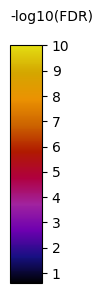

In [8]:
#Colour fold change legend
%matplotlib agg
fig,ax=enr.plot_legend_enrichment_bar(cmap=CMAP_FDR_BAR, min_FDR=MIN_FDR_BAR,used_padj=PADJ,base=LFDR_BASE_BAR)
display(fig)

### Enrichment for expression_minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30.pdf

In [ ]:
#Old code
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30.tab',index_col=0)
for group in range(1,len(regulons['Cluster'].unique())+1):
    enriched=group_diff_enrichment(data=regulons,group='C'+str(group),min_overlap=2)
    if save_enrichment and enriched is not None:
        enriched.to_csv(pathRegulons+'enrichment/minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30_enrichment_cluster'+str(group)+'.tsv', sep='\t',index=False)

#### Using only genes annotated with at least one gene set 
To find genes that have gene set annotations only gene sets used in enrichment are used (see above). Genes that are in at least one of these gene sets are used for enrichment calculation, both for reference and gene group of interest (query).

***  C1 selected: 30 with EID: 30
Genes annotated with a gene set in reference 37.8% and group 73.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 20 out of 22 group genes used for enrichment calculation.


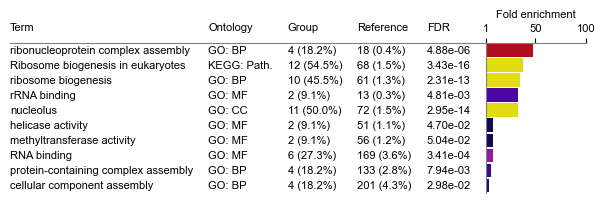

***  C2 selected: 66 with EID: 65
Genes annotated with a gene set in reference 37.8% and group 63.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 34 out of 41 group genes used for enrichment calculation.


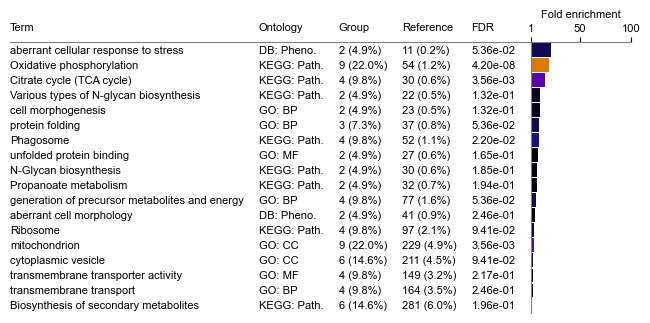

***  C3 selected: 68 with EID: 68
Genes annotated with a gene set in reference 37.8% and group 97.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 62 out of 66 group genes used for enrichment calculation.


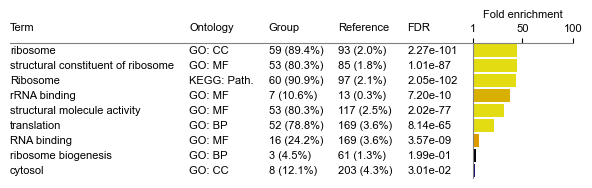

***  C4 selected: 55 with EID: 55
Genes annotated with a gene set in reference 37.8% and group 49.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 18 out of 27 group genes used for enrichment calculation.


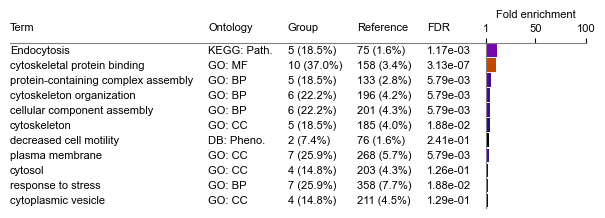

***  C5 selected: 41 with EID: 41
Genes annotated with a gene set in reference 37.8% and group 98.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 35 out of 40 group genes used for enrichment calculation.


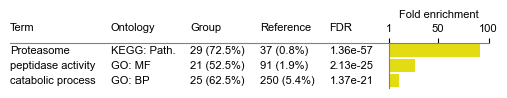

***  C6 selected: 74 with EID: 74
Genes annotated with a gene set in reference 37.8% and group 55.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 33 out of 41 group genes used for enrichment calculation.


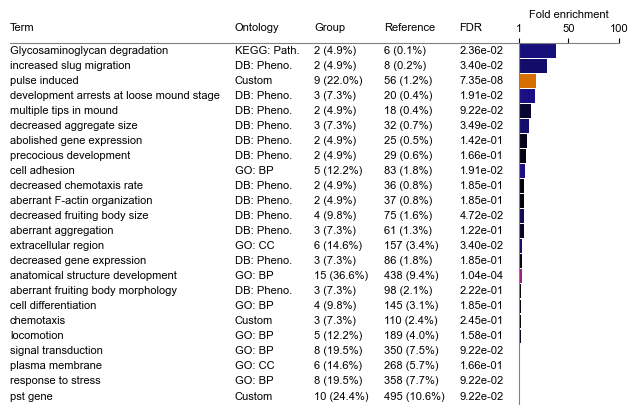

***  C7 selected: 40 with EID: 40
Genes annotated with a gene set in reference 37.8% and group 40.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 14 out of 16 group genes used for enrichment calculation.


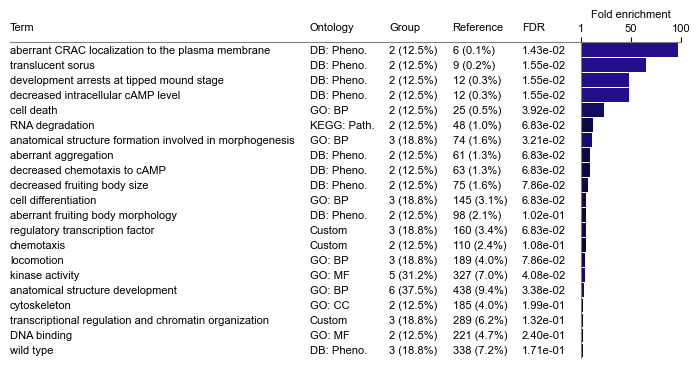

***  C8 selected: 23 with EID: 23
Genes annotated with a gene set in reference 37.8% and group 43.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 6 out of 10 group genes used for enrichment calculation.


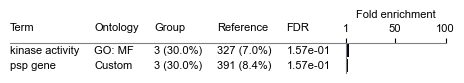

***  C9 selected: 20 with EID: 20
Genes annotated with a gene set in reference 37.8% and group 90.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 18 out of 18 group genes used for enrichment calculation.


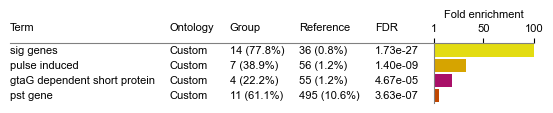

***  C10 selected: 36 with EID: 36
Genes annotated with a gene set in reference 37.8% and group 53.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 18 out of 19 group genes used for enrichment calculation.


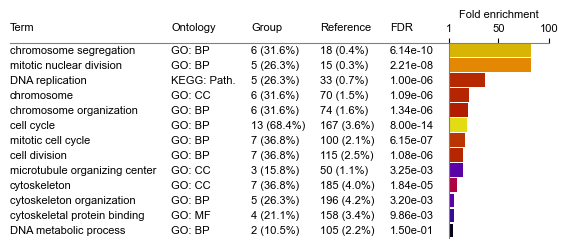

***  C11 selected: 77 with EID: 77
Genes annotated with a gene set in reference 37.8% and group 36.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 14 out of 28 group genes used for enrichment calculation.


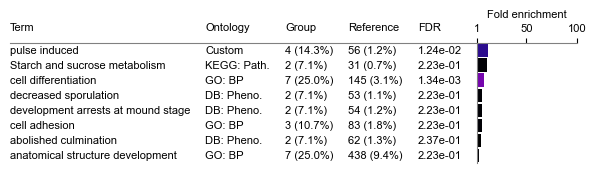

***  C12 selected: 57 with EID: 57
Genes annotated with a gene set in reference 37.8% and group 61.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 23 out of 35 group genes used for enrichment calculation.


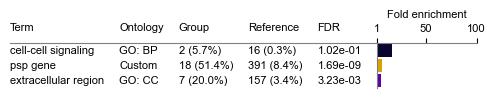

***  C13 selected: 64 with EID: 64
Genes annotated with a gene set in reference 37.8% and group 80.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 43 out of 51 group genes used for enrichment calculation.


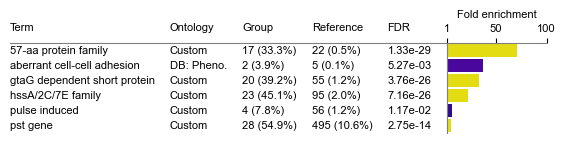

***  C14 selected: 19 with EID: 19
Genes annotated with a gene set in reference 37.8% and group 84.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 14 out of 16 group genes used for enrichment calculation.


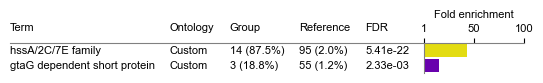

***  C15 selected: 91 with EID: 91
Genes annotated with a gene set in reference 37.8% and group 74.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 55 out of 67 group genes used for enrichment calculation.


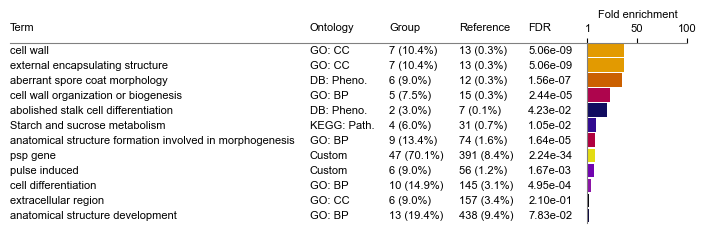

***  C16 selected: 74 with EID: 74
Genes annotated with a gene set in reference 37.8% and group 53.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 36 out of 39 group genes used for enrichment calculation.


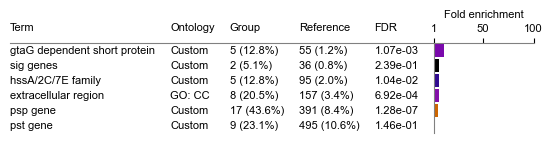

***  C17 selected: 61 with EID: 59
Genes annotated with a gene set in reference 37.8% and group 39.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 15 out of 23 group genes used for enrichment calculation.


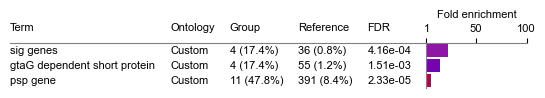

***  C18 selected: 46 with EID: 45
Genes annotated with a gene set in reference 37.8% and group 42.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 15 out of 19 group genes used for enrichment calculation.


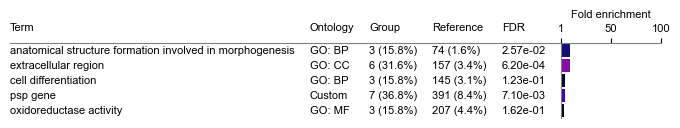

***  C19 selected: 58 with EID: 58
Genes annotated with a gene set in reference 37.8% and group 31.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 17 out of 18 group genes used for enrichment calculation.


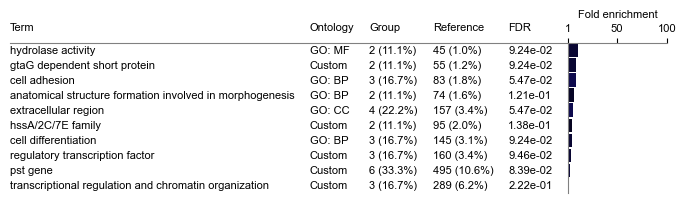

***  C20 selected: 54 with EID: 54
Genes annotated with a gene set in reference 37.8% and group 37.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 7 out of 20 group genes used for enrichment calculation.


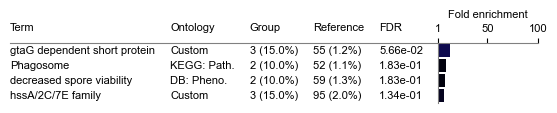

***  C21 selected: 45 with EID: 45
Genes annotated with a gene set in reference 37.8% and group 27.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 8 out of 12 group genes used for enrichment calculation.


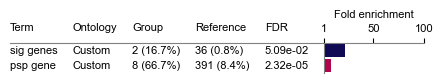

In [69]:
%matplotlib agg
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30.tab',index_col=0)
figs=[]
for group in range(1,len(regulons['Cluster'].unique())+1):
#for group in [1,2]:
    enriched=enr.group_diff_enrichment(query_names=list(regulons.query('Cluster =="'+'C'+str(group)+'"').index),
                                       group='C'+str(group),
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=CMAP_FDR_BAR,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
    if  save_enrichment and enriched is not None:
        enriched[0].to_csv(pathRegulons+'enrichment/minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30_annotatedOnly_enrichment_cluster'+str(group)+'.tsv', sep='\t',index=False)
plt.close('all')    

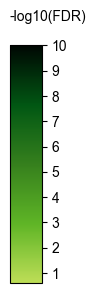

***  C1 selected: 30 with EID: 30
Genes annotated with a gene set in reference 37.8% and group 73.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 20 out of 22 group genes used for enrichment calculation.


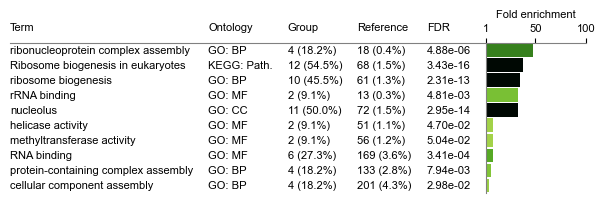

***  C2 selected: 66 with EID: 65
Genes annotated with a gene set in reference 37.8% and group 63.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 34 out of 41 group genes used for enrichment calculation.


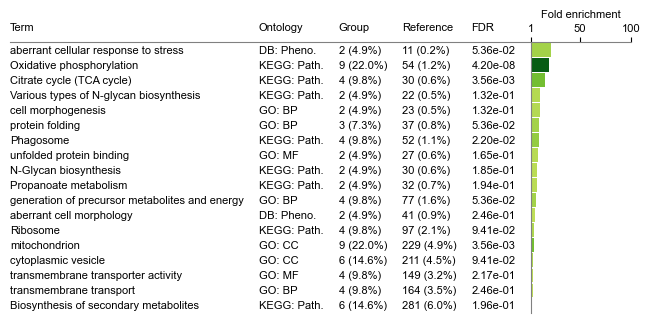

***  C3 selected: 68 with EID: 68
Genes annotated with a gene set in reference 37.8% and group 97.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 62 out of 66 group genes used for enrichment calculation.


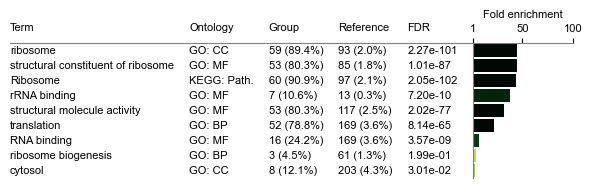

***  C4 selected: 55 with EID: 55
Genes annotated with a gene set in reference 37.8% and group 49.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 18 out of 27 group genes used for enrichment calculation.


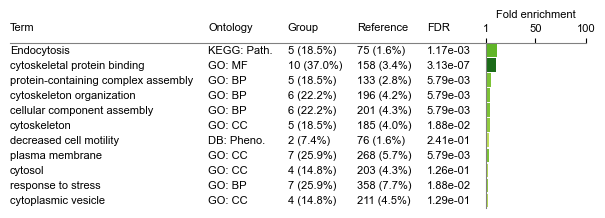

***  C5 selected: 41 with EID: 41
Genes annotated with a gene set in reference 37.8% and group 98.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 35 out of 40 group genes used for enrichment calculation.


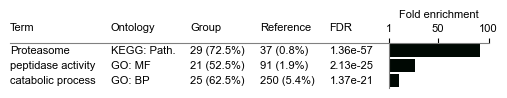

***  C6 selected: 74 with EID: 74
Genes annotated with a gene set in reference 37.8% and group 55.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 33 out of 41 group genes used for enrichment calculation.


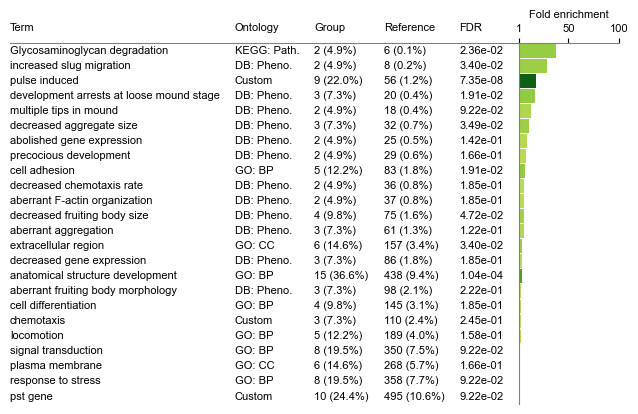

***  C7 selected: 40 with EID: 40
Genes annotated with a gene set in reference 37.8% and group 40.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 14 out of 16 group genes used for enrichment calculation.


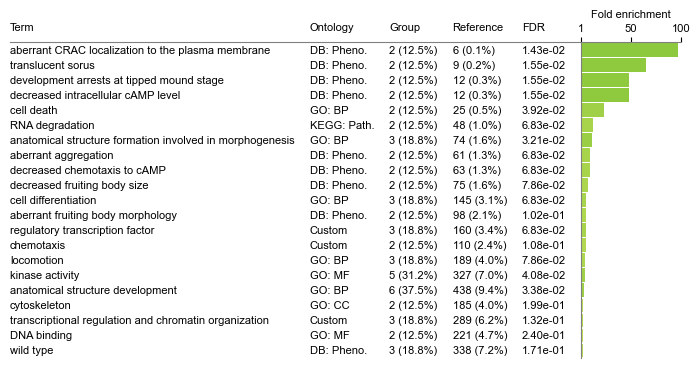

***  C8 selected: 23 with EID: 23
Genes annotated with a gene set in reference 37.8% and group 43.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 6 out of 10 group genes used for enrichment calculation.


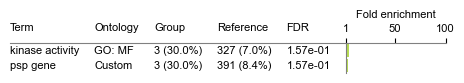

***  C9 selected: 20 with EID: 20
Genes annotated with a gene set in reference 37.8% and group 90.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 18 out of 18 group genes used for enrichment calculation.


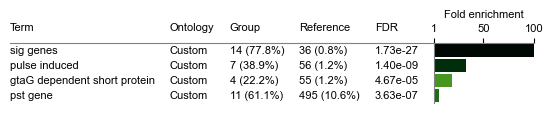

***  C10 selected: 36 with EID: 36
Genes annotated with a gene set in reference 37.8% and group 53.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 18 out of 19 group genes used for enrichment calculation.


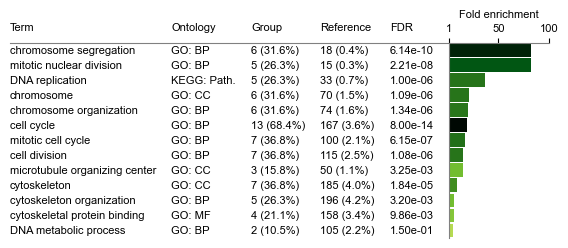

***  C11 selected: 77 with EID: 77
Genes annotated with a gene set in reference 37.8% and group 36.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 14 out of 28 group genes used for enrichment calculation.


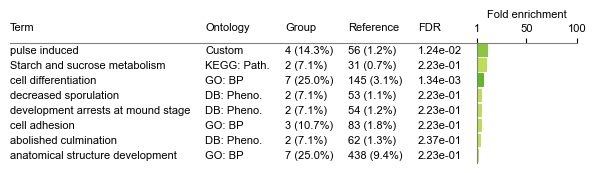

***  C12 selected: 57 with EID: 57
Genes annotated with a gene set in reference 37.8% and group 61.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 23 out of 35 group genes used for enrichment calculation.


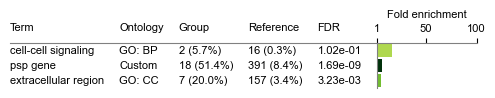

***  C13 selected: 64 with EID: 64
Genes annotated with a gene set in reference 37.8% and group 80.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 43 out of 51 group genes used for enrichment calculation.


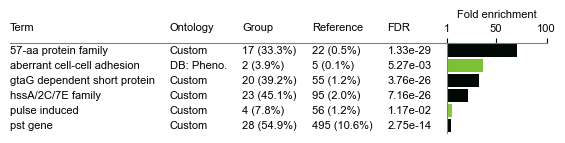

***  C14 selected: 19 with EID: 19
Genes annotated with a gene set in reference 37.8% and group 84.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 14 out of 16 group genes used for enrichment calculation.


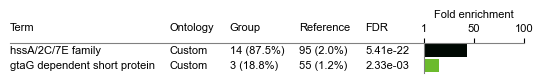

***  C15 selected: 91 with EID: 91
Genes annotated with a gene set in reference 37.8% and group 74.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 55 out of 67 group genes used for enrichment calculation.


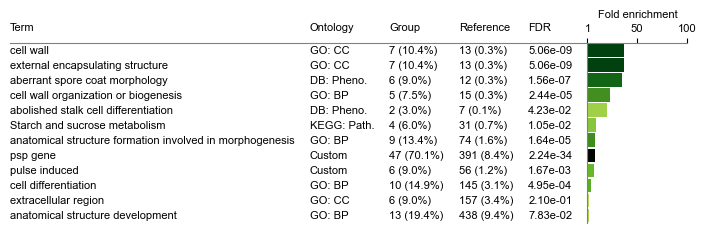

***  C16 selected: 74 with EID: 74
Genes annotated with a gene set in reference 37.8% and group 53.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 36 out of 39 group genes used for enrichment calculation.


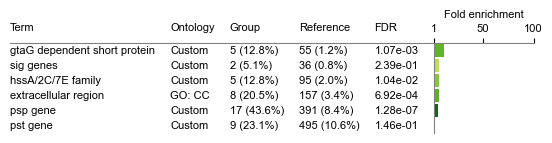

***  C17 selected: 61 with EID: 59
Genes annotated with a gene set in reference 37.8% and group 39.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 15 out of 23 group genes used for enrichment calculation.


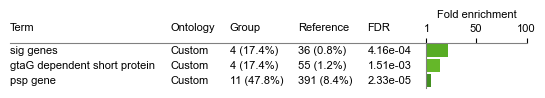

***  C18 selected: 46 with EID: 45
Genes annotated with a gene set in reference 37.8% and group 42.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 15 out of 19 group genes used for enrichment calculation.


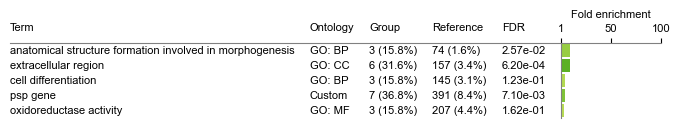

***  C19 selected: 58 with EID: 58
Genes annotated with a gene set in reference 37.8% and group 31.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 17 out of 18 group genes used for enrichment calculation.


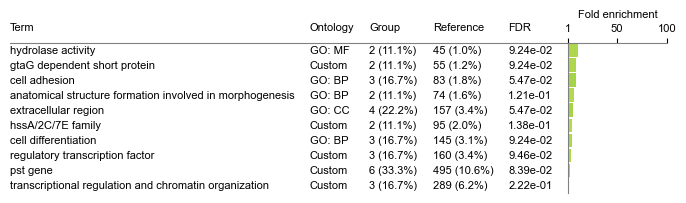

***  C20 selected: 54 with EID: 54
Genes annotated with a gene set in reference 37.8% and group 37.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 7 out of 20 group genes used for enrichment calculation.


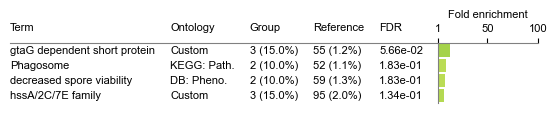

***  C21 selected: 45 with EID: 45
Genes annotated with a gene set in reference 37.8% and group 27.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 8 out of 12 group genes used for enrichment calculation.


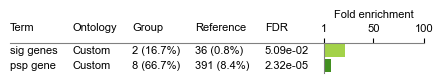

In [70]:
#Colour fold change legend
cmap=['#bede57','#5fb526','#36801d','#015713','#000803']
%matplotlib agg
fig,ax=enr.plot_legend_enrichment_bar(cmap=cmap, min_FDR=MIN_FDR_BAR,used_padj=PADJ,base=LFDR_BASE_BAR)
display(fig)
%matplotlib agg
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30.tab',index_col=0)
figs=[]
for group in range(1,len(regulons['Cluster'].unique())+1):
#for group in [1,2]:
    enriched=enr.group_diff_enrichment(query_names=list(regulons.query('Cluster =="'+'C'+str(group)+'"').index),
                                       group='C'+str(group),
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=cmap,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
    if  save_enrichment and enriched is not None:
        enriched[0].to_csv(pathRegulons+'enrichment/minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30_annotatedOnly_enrichment_cluster'+str(group)+'.tsv', sep='\t',index=False)
plt.close('all')    

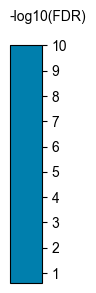

***  C1 selected: 30 with EID: 30
Genes annotated with a gene set in reference 37.8% and group 73.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 20 out of 22 group genes used for enrichment calculation.


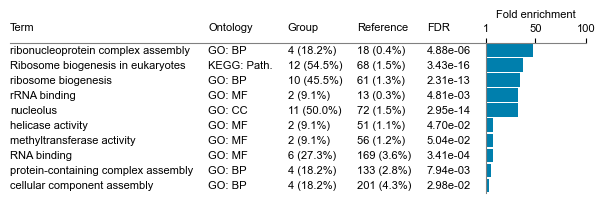

***  C2 selected: 66 with EID: 65
Genes annotated with a gene set in reference 37.8% and group 63.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 34 out of 41 group genes used for enrichment calculation.


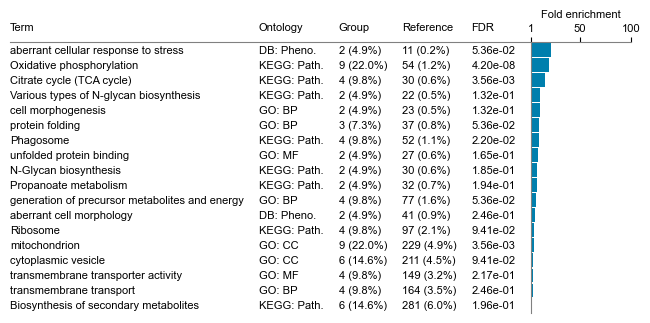

***  C3 selected: 68 with EID: 68
Genes annotated with a gene set in reference 37.8% and group 97.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 62 out of 66 group genes used for enrichment calculation.


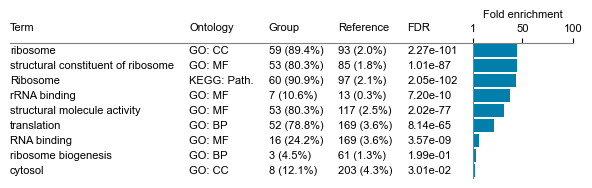

***  C4 selected: 55 with EID: 55
Genes annotated with a gene set in reference 37.8% and group 49.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 18 out of 27 group genes used for enrichment calculation.


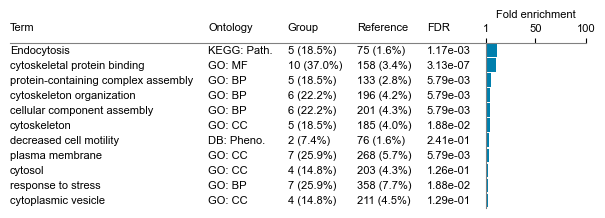

***  C5 selected: 41 with EID: 41
Genes annotated with a gene set in reference 37.8% and group 98.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 35 out of 40 group genes used for enrichment calculation.


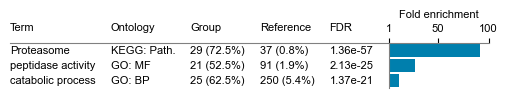

***  C6 selected: 74 with EID: 74
Genes annotated with a gene set in reference 37.8% and group 55.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 33 out of 41 group genes used for enrichment calculation.


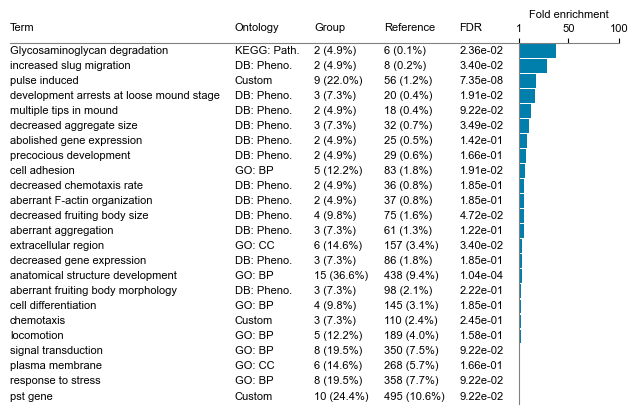

***  C7 selected: 40 with EID: 40
Genes annotated with a gene set in reference 37.8% and group 40.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 14 out of 16 group genes used for enrichment calculation.


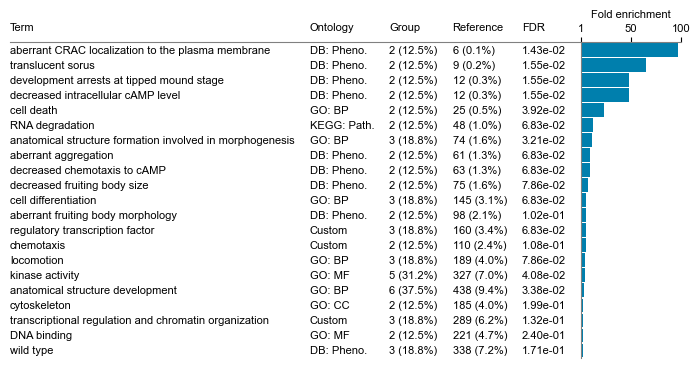

***  C8 selected: 23 with EID: 23
Genes annotated with a gene set in reference 37.8% and group 43.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 6 out of 10 group genes used for enrichment calculation.


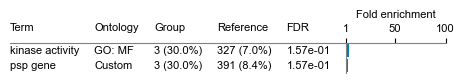

***  C9 selected: 20 with EID: 20
Genes annotated with a gene set in reference 37.8% and group 90.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 18 out of 18 group genes used for enrichment calculation.


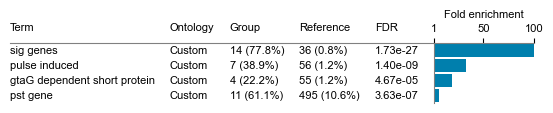

***  C10 selected: 36 with EID: 36
Genes annotated with a gene set in reference 37.8% and group 53.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 18 out of 19 group genes used for enrichment calculation.


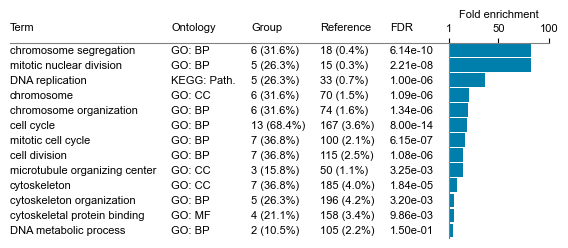

***  C11 selected: 77 with EID: 77
Genes annotated with a gene set in reference 37.8% and group 36.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 14 out of 28 group genes used for enrichment calculation.


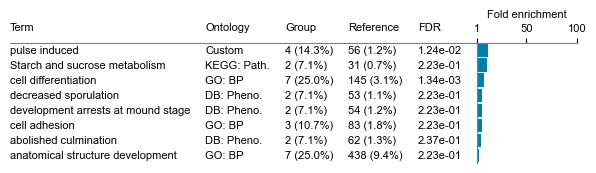

***  C12 selected: 57 with EID: 57
Genes annotated with a gene set in reference 37.8% and group 61.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 23 out of 35 group genes used for enrichment calculation.


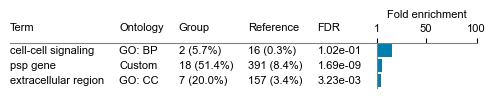

***  C13 selected: 64 with EID: 64
Genes annotated with a gene set in reference 37.8% and group 80.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 43 out of 51 group genes used for enrichment calculation.


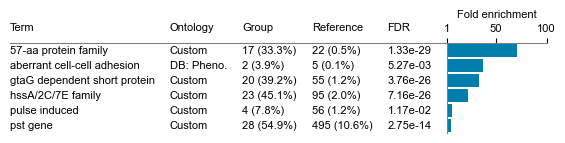

***  C14 selected: 19 with EID: 19
Genes annotated with a gene set in reference 37.8% and group 84.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 14 out of 16 group genes used for enrichment calculation.


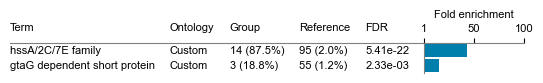

***  C15 selected: 91 with EID: 91
Genes annotated with a gene set in reference 37.8% and group 74.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 55 out of 67 group genes used for enrichment calculation.


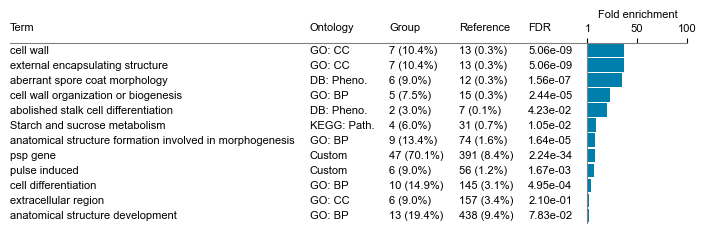

***  C16 selected: 74 with EID: 74
Genes annotated with a gene set in reference 37.8% and group 53.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 36 out of 39 group genes used for enrichment calculation.


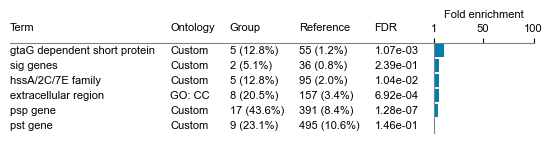

***  C17 selected: 61 with EID: 59
Genes annotated with a gene set in reference 37.8% and group 39.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 15 out of 23 group genes used for enrichment calculation.


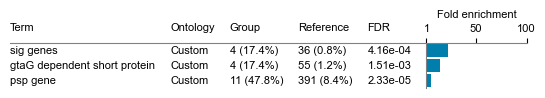

***  C18 selected: 46 with EID: 45
Genes annotated with a gene set in reference 37.8% and group 42.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 15 out of 19 group genes used for enrichment calculation.


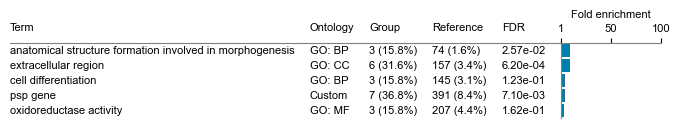

***  C19 selected: 58 with EID: 58
Genes annotated with a gene set in reference 37.8% and group 31.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 17 out of 18 group genes used for enrichment calculation.


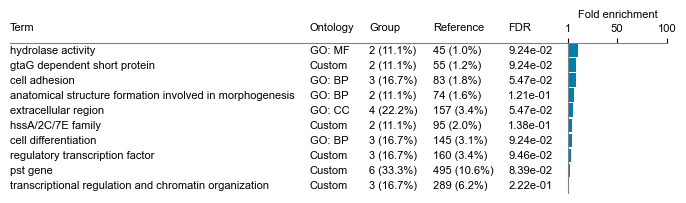

***  C20 selected: 54 with EID: 54
Genes annotated with a gene set in reference 37.8% and group 37.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 7 out of 20 group genes used for enrichment calculation.


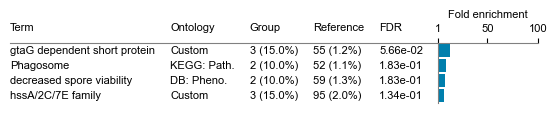

***  C21 selected: 45 with EID: 45
Genes annotated with a gene set in reference 37.8% and group 27.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 8 out of 12 group genes used for enrichment calculation.


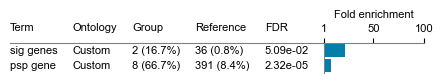

In [71]:
#Colour fold change legend
cmap=['#007fad','#007fad']
%matplotlib agg
fig,ax=enr.plot_legend_enrichment_bar(cmap=cmap, min_FDR=MIN_FDR_BAR,used_padj=PADJ,base=LFDR_BASE_BAR)
display(fig)
%matplotlib agg
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30.tab',index_col=0)
figs=[]
for group in range(1,len(regulons['Cluster'].unique())+1):
#for group in [1,2]:
    enriched=enr.group_diff_enrichment(query_names=list(regulons.query('Cluster =="'+'C'+str(group)+'"').index),
                                       group='C'+str(group),
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=cmap,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
    if  save_enrichment and enriched is not None:
        enriched[0].to_csv(pathRegulons+'enrichment/minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30_annotatedOnly_enrichment_cluster'+str(group)+'.tsv', sep='\t',index=False)
plt.close('all')  

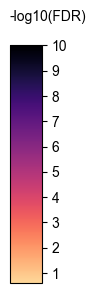

***  C1 selected: 30 with EID: 30
Genes annotated with a gene set in reference 37.8% and group 73.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 20 out of 22 group genes used for enrichment calculation.


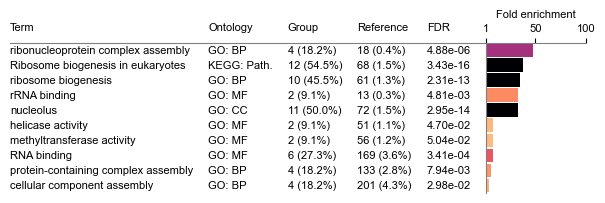

***  C2 selected: 66 with EID: 65
Genes annotated with a gene set in reference 37.8% and group 63.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 34 out of 41 group genes used for enrichment calculation.


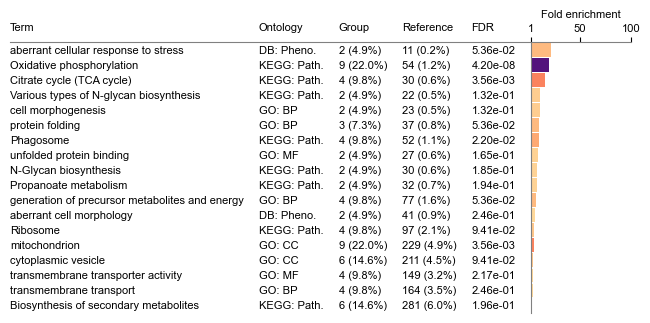

***  C3 selected: 68 with EID: 68
Genes annotated with a gene set in reference 37.8% and group 97.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 62 out of 66 group genes used for enrichment calculation.


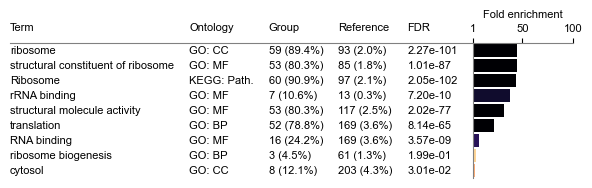

***  C4 selected: 55 with EID: 55
Genes annotated with a gene set in reference 37.8% and group 49.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 18 out of 27 group genes used for enrichment calculation.


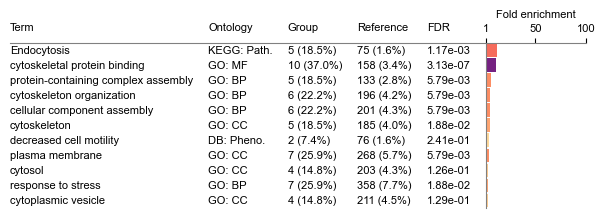

***  C5 selected: 41 with EID: 41
Genes annotated with a gene set in reference 37.8% and group 98.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 35 out of 40 group genes used for enrichment calculation.


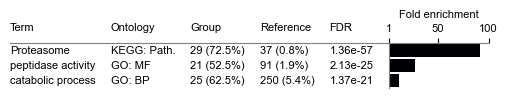

***  C6 selected: 74 with EID: 74
Genes annotated with a gene set in reference 37.8% and group 55.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 33 out of 41 group genes used for enrichment calculation.


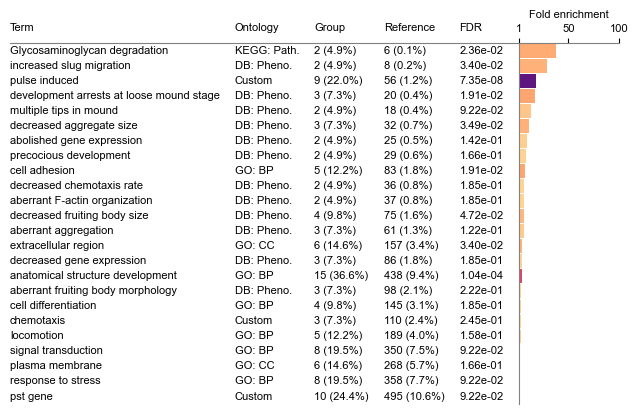

***  C7 selected: 40 with EID: 40
Genes annotated with a gene set in reference 37.8% and group 40.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 14 out of 16 group genes used for enrichment calculation.


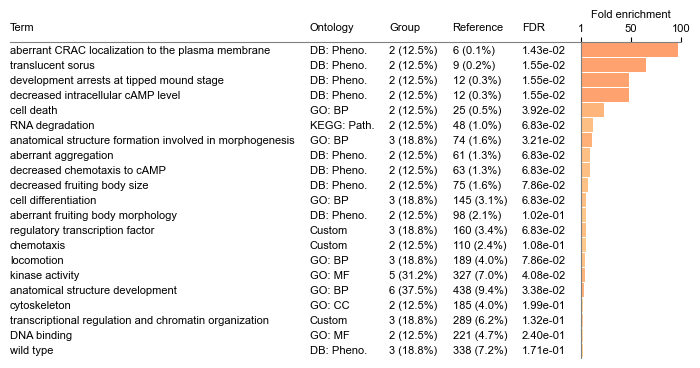

***  C8 selected: 23 with EID: 23
Genes annotated with a gene set in reference 37.8% and group 43.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 6 out of 10 group genes used for enrichment calculation.


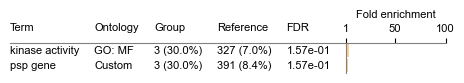

***  C9 selected: 20 with EID: 20
Genes annotated with a gene set in reference 37.8% and group 90.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 18 out of 18 group genes used for enrichment calculation.


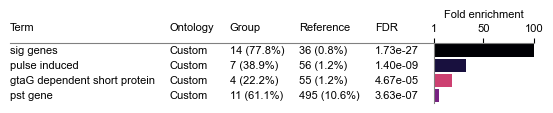

***  C10 selected: 36 with EID: 36
Genes annotated with a gene set in reference 37.8% and group 53.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 18 out of 19 group genes used for enrichment calculation.


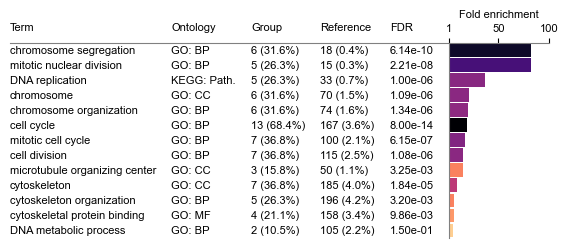

***  C11 selected: 77 with EID: 77
Genes annotated with a gene set in reference 37.8% and group 36.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 14 out of 28 group genes used for enrichment calculation.


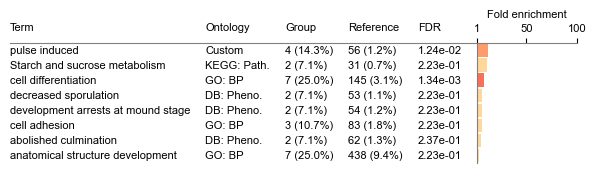

***  C12 selected: 57 with EID: 57
Genes annotated with a gene set in reference 37.8% and group 61.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 23 out of 35 group genes used for enrichment calculation.


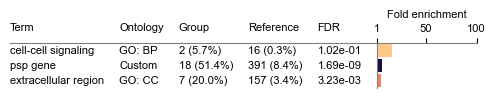

***  C13 selected: 64 with EID: 64
Genes annotated with a gene set in reference 37.8% and group 80.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 43 out of 51 group genes used for enrichment calculation.


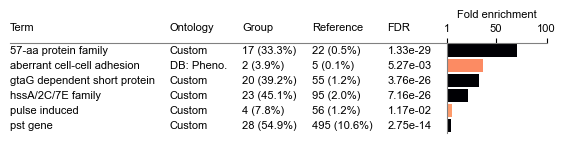

***  C14 selected: 19 with EID: 19
Genes annotated with a gene set in reference 37.8% and group 84.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 14 out of 16 group genes used for enrichment calculation.


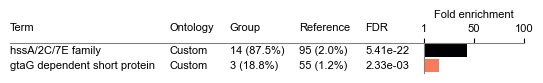

***  C15 selected: 91 with EID: 91
Genes annotated with a gene set in reference 37.8% and group 74.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 55 out of 67 group genes used for enrichment calculation.


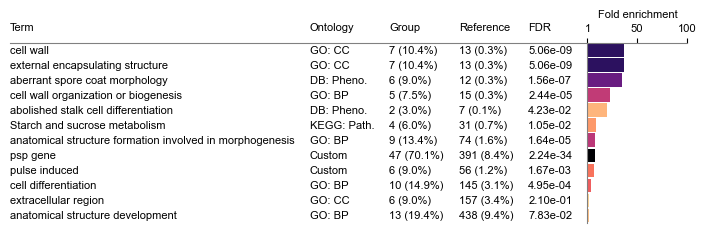

***  C16 selected: 74 with EID: 74
Genes annotated with a gene set in reference 37.8% and group 53.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 36 out of 39 group genes used for enrichment calculation.


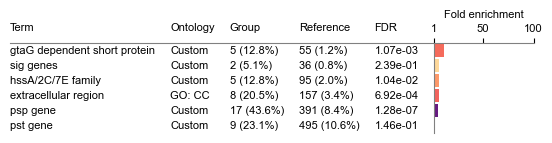

***  C17 selected: 61 with EID: 59
Genes annotated with a gene set in reference 37.8% and group 39.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 15 out of 23 group genes used for enrichment calculation.


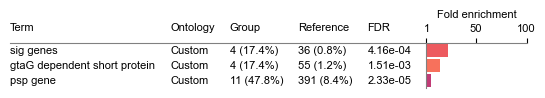

***  C18 selected: 46 with EID: 45
Genes annotated with a gene set in reference 37.8% and group 42.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 15 out of 19 group genes used for enrichment calculation.


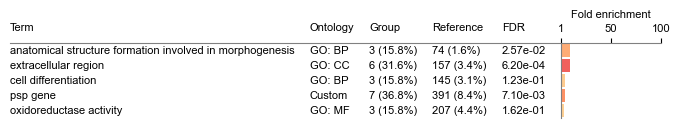

***  C19 selected: 58 with EID: 58
Genes annotated with a gene set in reference 37.8% and group 31.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 17 out of 18 group genes used for enrichment calculation.


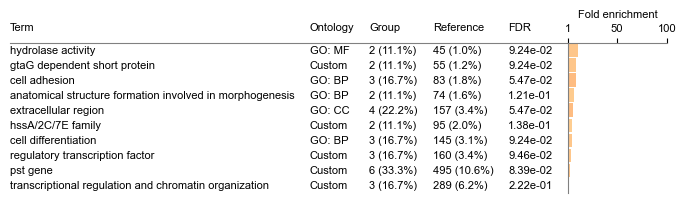

***  C20 selected: 54 with EID: 54
Genes annotated with a gene set in reference 37.8% and group 37.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 7 out of 20 group genes used for enrichment calculation.


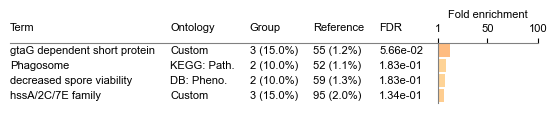

***  C21 selected: 45 with EID: 45
Genes annotated with a gene set in reference 37.8% and group 27.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 8 out of 12 group genes used for enrichment calculation.


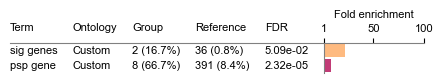

In [72]:
cmap= matplotlib.cm.get_cmap('magma_r').colors[20:]
%matplotlib agg
fig,ax=enr.plot_legend_enrichment_bar(cmap=cmap, min_FDR=MIN_FDR_BAR,used_padj=PADJ,base=LFDR_BASE_BAR)
display(fig)
%matplotlib agg
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30.tab',index_col=0)
figs=[]
for group in range(1,len(regulons['Cluster'].unique())+1):
#for group in [1,2]:
    enriched=enr.group_diff_enrichment(query_names=list(regulons.query('Cluster =="'+'C'+str(group)+'"').index),
                                       group='C'+str(group),
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=cmap,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
    if  save_enrichment and enriched is not None:
        enriched[0].to_csv(pathRegulons+'enrichment/minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30_annotatedOnly_enrichment_cluster'+str(group)+'.tsv', sep='\t',index=False)
plt.close('all')  

### Enrichment for mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log.tab

In [ ]:
#Old code
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log.tab',index_col=0)
for group in range(1,len(regulons['Cluster'].unique())+1):
    cluster='C'+str(group)
    print('*** Cluster %s (%s)' %(cluster,string.ascii_uppercase[group-1]))
    enriched=group_diff_enrichment(data=regulons,group=cluster,min_overlap=2)
    if  save_enrichment and enriched is not None:
        enriched.to_csv(pathRegulons+'enrichment/minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log_enrichment_cluster'+str(group)+'.tsv', sep='\t',index=False)

#### Using only genes annotated with at least one gene set

In [ ]:
%matplotlib agg
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log.tab',index_col=0)
figs=[]
for group in range(1,len(regulons['Cluster'].unique())+1):
#for group in [1,2]:
    cluster='C'+str(group)
    print('*** Cluster %s (%s)' %(cluster,string.ascii_uppercase[group-1]))
    enriched=enr.group_diff_enrichment(query_names=list(regulons.query('Cluster =="'+'C'+str(group)+'"').index),
                                       group=cluster,
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,
                                       cmap_FDR_bar=CMAP_FDR_BAR,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
    if  save_enrichment and enriched is not None:
        enriched[0].to_csv(pathRegulons+'enrichment/mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log'+str(group)+'.tsv', sep='\t',index=False)
plt.close('all')    

#### Use all GO gene sets (not only slims)

In [ ]:
# Get all gene sets
gene_sets=list(list_all(organism='44689'))
gene_sets_ontology=enr.get_gene_sets(gene_set_names=gene_sets, go_slims=False,set_sizes=(5,500))
# Find out max/min gene set sizes and N sets
max_n=0
min_n=np.inf
for k,v in gene_sets_ontology.items():
    for s in v:
        n=len(s.genes)
        if n<min_n:
            min_n=n
        if n>max_n:
            max_n=n
print('Min size',min_n,'Max size',max_n)  
print('N sets',{k:len(v) for k,v in gene_sets_ontology.items()},'\n')

%matplotlib agg
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log.tab',index_col=0)
figs=[]
for group in range(1,len(regulons['Cluster'].unique())+1):
#for group in [1,2]:
    cluster='C'+str(group)
    print('*** Cluster %s (%s)' %(cluster,string.ascii_uppercase[group-1]))
    enriched=enr.group_diff_enrichment(query_names=list(regulons.query('Cluster =="'+'C'+str(group)+'"').index),
                                       group=cluster,
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,
                                       cmap_FDR_bar=cmap,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
plt.close('all')